<a href="https://colab.research.google.com/github/kpahwa16/BioFacenet-Pytorch-Implementation/blob/main/VMG_augmented_CelebA_BioFacenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING THE REQUIRED PACKAGES

In [110]:
import os
import h5py
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms
from PIL import Image
import zipfile 
import gdown

In [3]:
%cd /content 

/content


# Loading converted .npy files to read the utiliy files in the .mat format provided in the repo

# **CLONING BIOFACENET MATLAB REPOSITORY TO GET ACCESS TO THE MATLAB UTILITY FILES REQUIRED FOR THE FUCNTIONS** : [link text](https://github.com/ssma502/BioFaces.git)

In [111]:
import os
import gdown
data_root = '/content/Biofacenet_matlab/'
import zipfile 
from zipfile import *
dataset_folder = f'{data_root}/'
download_path = f'{data_root}/'

if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)
os.chdir(data_root)
%pwd
!git clone https://github.com/ssma502/BioFaces.git

fatal: destination path 'BioFaces' already exists and is not an empty directory.


# Converting the .mat files into .npy files

In [112]:
dir = "/content/Biofacenet_matlab/BioFaces/util/"
destination_dir = "/content/Biofacenet_matlab/npy/"

if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)
for files in os.listdir(dir):
  file_mat = scipy.io.loadmat(dir + files)
  file_mat_keys = list(file_mat.keys())
  name = file_mat_keys[3]
  value = file_mat[name]
  np.save(destination_dir + str(name) + ".npy", value )
  globals()[f"{name}"] = np.load(destination_dir+ str(name) + ".npy", allow_pickle = True)

# CONVERTING MATLAB FILES FROM REPO INTO PYTORCH 

# CameraSensitivityPCA.m : 

In [113]:
from sklearn.decomposition import PCA
def CameraSensitivityPCA(cmf):
  wavelength=33
  cmf = np.moveaxis(cmf, 1, -1)
  cmf /= np.sum(cmf, axis=-1)[..., np.newaxis]
  cmf = np.moveaxis(cmf, -1, 1).reshape((wavelength*3, -1)).T # (3, 33, 28) -> (99, 28) -> (28, 99)
  mu = np.mean(cmf, axis=0) # (99,)
  pca = PCA(n_components=cmf.shape[0]-1 if cmf.shape[0]-1 <= 3 * wavelength else cmf.shape[1])
  score = pca.fit_transform(cmf) 
  PC = pca.components_ 
  cmf -= np.mean(cmf, axis=0)
  cov_matrix = np.dot(cmf.T, cmf) / cmf.shape[0]
  EV = np.array([np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in PC]) # EVs are sorted in descending order.
  PC = PC[:2,:].T @ np.diag(np.sqrt(EV[:2])) # only taking the first two components 
  return PC, mu, EV[:2]

PC, mu, EV = CameraSensitivityPCA(np.array(list(rgbCMF[0])))



# cameraModel.m : Sensitivity parameters for the three channels



In [114]:
def cameraModel(mu, PC, b, wavelength):
  S = b @ PC.T + mu # (B, 2) @ (2, 99) + (99,) -> (B, 99)
  S  = F.relu(S)
  Sr, Sg, Sb = S[:,:wavelength], S[:,wavelength:2*wavelength], S[:,2*wavelength:]
  return Sr, Sg, Sb # (B, 33) ea.

# computelightcolour.m

In [115]:
def computelightcolour(e, Sr, Sg, Sb):
  lightcolour = torch.stack([torch.sum(Sr* e, dim=1), torch.sum(Sg * e, dim=1), torch.sum(Sb * e, dim=1)], dim=1)
  return lightcolour # (B, 3)

# computeSpecularities.m

In [116]:
def computeSpecularities(specmask, lightcolour):
  return specmask * lightcolour.unsqueeze(-1).unsqueeze(-1)

# WhiteBalance.m

In [117]:
def WhiteBalance(rawAppearance, lightcolour):
  ImwhiteBalanced = rawAppearance / lightcolour.unsqueeze(-1).unsqueeze(-1) # (B, 3, H, W) / (B, 3, 1, 1)
  return ImwhiteBalanced # (B, 3, H, W)

# findT.m

In [118]:
def findT(Tmatrix, BGrid):
  T_raw2xyz = F.grid_sample(input=torch.moveaxis(Tmatrix, -1, 1), 
                            grid=torch.moveaxis(BGrid, 1, -1))
  return T_raw2xyz

# fromRawTosRGB.m

In [119]:
def fromRawTosRGB(imWB,T_RAW2XYZ):
  # image_white_balanced: (B, 3, H, W)
  # t_raw2xyz: (B, 9, 1, 1)
  Ix = T_RAW2XYZ[:,0] * imWB[:,0] + T_RAW2XYZ[:,3] * imWB[:,1] + T_RAW2XYZ[:,6] * imWB[:,2] # (B, H, W)
  Iy = T_RAW2XYZ[:,1] * imWB[:,0] + T_RAW2XYZ[:,4] * imWB[:,1] + T_RAW2XYZ[:,7] * imWB[:,2]
  Iz = T_RAW2XYZ[:,2] * imWB[:,0] + T_RAW2XYZ[:,5] * imWB[:,1] + T_RAW2XYZ[:,8] * imWB[:,2]
  Ixyz = torch.stack([Ix,Iy, Iz], dim=1) # (B, 3, H, W)
  Txyzrgb  = torch.FloatTensor([3.2406, -0.9689, 0.0557, -1.5372, 1.8758, -0.2040, -0.4986, 0.0415, 1.057])
  R = Txyzrgb[0] * Ixyz[:,0] + Txyzrgb[3] * Ixyz[:,1] + Txyzrgb[6] * Ixyz[:,2] # (B, H, W) * (1,) -> (B, H, W)
  G = Txyzrgb[1] * Ixyz[:,0] + Txyzrgb[4] * Ixyz[:,1] + Txyzrgb[7] * Ixyz[:,2]
  B = Txyzrgb[2] * Ixyz[:,0] + Txyzrgb[5] * Ixyz[:,1] + Txyzrgb[8] * Ixyz[:,2]
  sRGBim = torch.stack([R,G,B], dim=1) # (B, 3, H, W)
  return F.relu(sRGBim)

# BiotoSpectralRef.m

In [120]:
def BiotoSpectralRF(fmel, fblood,Newskincolour):
  import torch.nn.functional as F
  BiophysicalMaps= torch.cat((fmel, fblood), dim=1).permute(0,2,3,1) # (b,2,h,w) -> (b,h,w,2)
  R_total = F.grid_sample(input=Newskincolour, grid=BiophysicalMaps)
  return R_total# (B, 33, H, W)

# ImageFormation.m

In [121]:
def ImageFormation(R_total, Sr, Sg, Sb, e, specularities, shading):
  # srgb: (B, 33) ea.
  # R_total: (B, 33, H, W)
  # e: (B, 33)
  # specularities: (B, C, H, W) where C is 1 or 3.
  # shading: (B, 1, H, W)
  spectraRef = R_total * e.unsqueeze(-1).unsqueeze(-1) # (B, 33, H, W) * (B, 33)
  rChannel = torch.sum(spectraRef * Sr.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True) # (B, 33, H, W) * (B, 33) sum -> (B, 1, H, W)
  gChannel = torch.sum(spectraRef * Sg.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  bChannel= torch.sum(spectraRef * Sb.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  diffuseAlbedo= torch.cat([rChannel, gChannel, bChannel], dim=1) # (B, 3, H, W)
  ShadedDiffuse = diffuseAlbedo * shading # (B, 3, H, W) * (B, 1, H, W) -> (B, 3, H, W)
  # diag(e) i_d r + diag(e) i_s
  rawAppearance = ShadedDiffuse + specularities
  return rawAppearance, diffuseAlbedo

# illuminationModel.m

In [122]:
def illuminationModel(weightA , weightD, Fweights ,CCT, illumA, illumDNorm, illumFNorm):
  illuminant_a = illumA * weightA.unsqueeze(-1) # (B, 33) * (B, 1) -> (B, 33)
  illuminant_d = (illumDNorm[:,torch.round(CCT).long()] * weightD).permute(1, 0) # (33, 22[sel B]) (B) -> (33, B) -> (B, 33)
  # illumFNorm: (33, 12) * Fweights: (B, 12) -> (B, 33, 12)
  illuminant_f = torch.stack([illumFNorm * f_weight for f_weight in Fweights])
  illuminant_f = torch.sum(illuminant_f, dim=2) # (B, 33)
  e = illuminant_a + illuminant_d + illuminant_f # (B, 33)
  e /= torch.sum(e, dim=0) # (B, 33) / (33) -> (B, 33)
  return e


# **MODEL**

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):

  def __init__(self, filters, light_vector_size=15, n_class=4, b_size=2, add_double_conv=True, copy_shading = False):
    super(UNet, self).__init__()
    filters = [3] + filters 
    self.filters = filters
    self.light_vector_size = light_vector_size
    self.b_size = b_size
    self.copy_shading = copy_shading
    self.n_class = n_class



    self.base_conv = lambda in_channels, out_channels: nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(out_channels, eps=1e-04),
      nn.ReLU()
    )

## As specified in MATLAB code 
    self.double_conv  = lambda channels: nn.Sequential(
      nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(channels, eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(channels, eps=1e-04),    
      nn.ReLU()
    )

    self.light_and_b_layer = nn.Sequential(
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(4,4)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(1,1)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], light_vector_size+b_size, kernel_size=(1, 1))
    )
    
    # Encoder layers
    self.encoder_layers = []
    for i in range(1, len(filters)):
      layer = nn.Sequential(self.base_conv(filters[i-1], filters[i]), self.double_conv(filters[i])) if add_double_conv else self.base_conv(filters[i-1], filters[i])
      self.encoder_layers.append(layer)
    
    # Decoder layers
    self.decoder_layers_by_class = []
    for i in range(n_class):
      decoder_layers = [nn.Conv2d(self.filters[1], 1, kernel_size=(3, 3), padding=1)]
      for i in range(1, len(filters)-1): 
        layer = nn.Sequential(self.base_conv(filters[i]+filters[i+1], filters[i]), self.double_conv(filters[i])) if add_double_conv else self.base_conv(filters[i]+filters[i+1], filters[i])
        decoder_layers.append(layer)
      self.decoder_layers_by_class.append(decoder_layers)
  
  def scalingNet(self, lighting_parameters,b, fmel, fblood, shading, specmask ):
    CCT = lighting_parameters[:,14]
    lighting_weights = F.softmax(lighting_parameters[:,:14], dim=1)
    weight_a = lighting_weights[:,0]
    weight_d = lighting_weights[:,1]
    f_weights = lighting_weights[:,2:14]
    CCT = ((22-1) / (1 + torch.exp(-CCT)))
    fmel = torch.sigmoid(fmel) * 2 - 1
    fblood = torch.sigmoid(fblood) * 2 - 1
    b_scaled = 6 * torch.sigmoid(b) - 3 
    BGrid = b_scaled.reshape(-1, self.b_size, 1, 1) / 3
    shading = torch.exp(shading)
    specmask = torch.exp(specmask)
    return weight_a, weight_d, f_weights, CCT, fmel, fblood, b_scaled, BGrid, shading, specmask 




  def forward(self, x_original):
    # Encode
    x = x_original
    x_skip = []
    for i in range(1, len(self.filters)):
      x = self.encoder_layers[i-1](x)
      if i != len(self.filters)-1:
        x_skip.append(x)
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=2)
    y = x


    # Decode
    predictions = []
    for c in range(self.n_class):
      # print("----class----")
      for i in range(len(self.filters)-2, -1, -1):
          if i > 0:
            x = F.interpolate(y if i == len(self.filters)-2 else x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat([x, x_skip[i-1]], dim=1)
          x = self.decoder_layers_by_class[c][i](x)
      predictions.append(x)
    f_mel, f_blood, shading, spec_mask = predictions
    print(f_mel.shape, f_blood.shape)

    if self.copy_shading:
      shading = torchvision.transforms.Grayscale()(x_original) / 255


    light_and_b_prediction = self.light_and_b_layer(y)
    light_prediction = light_and_b_prediction[:,:self.light_vector_size,...]
    b_prediction = light_and_b_prediction[:,self.light_vector_size:,...]

    weight_a, weight_d, f_weights, CCT, fmel, fblood,scaled_b_prediction, b_grid, shading, specmask  = self.scalingNet(light_prediction.squeeze(-1).squeeze(-1), b_prediction.squeeze(-1).squeeze(-1), f_mel, f_blood, shading, spec_mask)

    return {
      "light_prediction": light_prediction,
      "b_prediction": scaled_b_prediction,
      "b_grid": b_grid,
      "weightA": weight_a, "weightD": weight_d, "Fweights": f_weights, "CCT": CCT,
      "fmel": f_mel, "fblood": f_blood , "predictedShading": shading, "specmask": specmask
    }

def testing_model():
  x = torch.FloatTensor(16, 3, 64, 64)
  model = UNet(filters=[32, 64, 128, 256, 512])
  print([(key, value.shape) for key, value in model(x).items()])

unet_test()


torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])
[('light_prediction', torch.Size([16, 15, 1, 1])), ('b_prediction', torch.Size([16, 2])), ('b_grid', torch.Size([16, 2, 1, 1])), ('weightA', torch.Size([16])), ('weightD', torch.Size([16])), ('Fweights', torch.Size([16, 12])), ('CCT', torch.Size([16])), ('fmel', torch.Size([16, 1, 64, 64])), ('fblood', torch.Size([16, 1, 64, 64])), ('predictedShading', torch.Size([16, 1, 64, 64])), ('specmask', torch.Size([16, 1, 64, 64]))]


In [163]:
%cd "/content/Biofacenet_matlab/npy"

/content/Biofacenet_matlab/npy


# **DATASET LOADER FOR AUGMNENTED DATASET**

In [38]:
%cd /content


/content


In [ ]:
# Dataset link from https://github.com/zhixinshu/NeuralFaceEditing
if not os.path.exists("NeuralFaceEditingDataset"):
  os.mkdir("NeuralFaceEditingDataset")
  os.chdir("NeuralFaceEditingDataset")
  !gdown --id 1LjXVghcSLk18JQxmu6iu2mYGaRveoYS3
  !gdown --id 1j0yWt0VJHDNZRTKHQnQo3nQLATvY0z-O
  !gdown --id 1KFn4TYsup0srjc0yAuYRPouA4mpTSUb2
  !gdown --id 1IbLNiPmi6UqBAZQC2dO2r5keljMCKpbn
  !gdown --id 1tBYPjV4D-SiMOONmF4fwmV5pD_XS4Ury
  !gdown --id 1BcMqUrAwDe2r0uTgdWyPYRZP6_KOVodO
  !gdown --id 1puzmuG_zA9u7FdNT3RUabLRmP9A-hHBd
  !gdown --id 1G4SHb3RJiv7coyeXBisU854sPIa0mbZ_
  !gdown --id 1LlH0XSO5a8PzaorOE66Shtk2MpqCYsKr
  !gdown --id 12EXVMH2Xs5qJIO618tFk7BF_6iK43uIG
  !gdown --id 1VzJyRmwVYX8c5DZd30CQmtXZdxZcf3vV
  !gdown --id 1MC4fCRDzoB58u3sQKi1X1t9AFHwFLKso
  !gdown --id 1t4j47DtLtKmyO7khhOqzXsc1ebtyYHlK
  !gdown --id 1aLPvtebfzXIqSypTNWQYCwy1TAjQLLMj
  !gdown --id 1ie9ucPvheNa6YyeMMDl4J1b1NTtrkn-H
  !gdown --id 18N4sYJcvU2A3hFmz1QYN9TV_bWu34XGh
  os.chdir("..")
if not os.path.exists("/tmp/NeuralFaceEditingDataset"):
  os.makedirs("/tmp", exist_ok=True)
  !cp -r NeuralFaceEditingDataset /tmp/NeuralFaceEditingDataset

In [164]:
import tensorflow as tf
class CelebADataset(torch.utils.data.Dataset):
  def __init__(self, dataset_root_path="NeuralFaceEditingDataset", small=False):
    self.small = small
    self.image_tensor, self.light_tensor = self.datasetReader(dataset_root_path)

  def datasetReader(self, dataset_root_path):
    files = [f for f in os.listdir(dataset_root_path)]
    image_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "inmc_celebA" in f]
    light_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "lrgb_celebA" in f]
    image_tensors = [h5py.File(os.path.join(dataset_root_path, image_file), 'r')["zx_7"] for image_file in image_files]
    light_tensors = [h5py.File(os.path.join(dataset_root_path, light_file), 'r')["zx_7"] for light_file in light_files]
    image_tensor = self.h5py_dataset_merger(image_files, "zx_7", "/content/imagedata.h5")
    light_tensor = self.h5py_dataset_merger(light_files, "zx_7", "/content/lightdata.h5")
    return image_tensor, light_tensor
  
# combining h5py datasets 
  def h5py_dataset_merger(self, file_paths_to_concatenate, entry_key, destination_path):
 
    number_of_samples = [h5py.File(f, 'r')[entry_key].shape[0] for f in file_paths_to_concatenate]
    total_number_of_samples = sum(number_of_samples)
    sample_shape = h5py.File(file_paths_to_concatenate[0], 'r')[entry_key].shape[1:] # shape of a single sample
    layout = h5py.VirtualLayout(shape=(total_number_of_samples,) + sample_shape, dtype=np.float64)

    ptr = 0
    for i, source_file_name in enumerate(file_paths_to_concatenate):
      vsource = h5py.VirtualSource(source_file_name, entry_key, shape=(number_of_samples[i],) + sample_shape)
      layout[ptr:ptr+number_of_samples[i]] = vsource
      ptr += number_of_samples[i]
    assert ptr == total_number_of_samples, "dataset not combined properly"

    if os.path.exists(destination_path):
      os.remove(destination_path)
    with h5py.File(destination_path, 'w', libver='latest') as destination_file:
      destination_file.create_virtual_dataset(entry_key, layout)

    return h5py.File(destination_path, 'r')[entry_key]
  
  def shading_calculation(self, normal, light):
    """
    normal: (3, H, W)
    light: (3, 9)
    """
    from skimage import color
    augmented_normal = np.concatenate([normal, np.ones_like(normal[0][np.newaxis, ...])], axis=0) # (4, 64, 64)
    augmented_normal_transposed = np.moveaxis(augmented_normal, 0, -1) # (64, 64, 4)
    shading_responses = []
    for L in light: # compute shading across red, green, blue
      c1, c2, c3, c4, c5 = 0.429043, 0.511664, 0.743125, 0.886227, 0.247708
      K = np.array([[c1*L[8], c1*L[4], c1*L[7], c2*L[3]],
                    [c1*L[4], -c1*L[8], c1*L[5], c2*L[1]],
                    [c1*L[7], c1*L[5], c3*L[6], c2*L[2]],
                    [c2*L[3], c2*L[1], c2*L[2], c4*L[0] - c5*L[6]]])
      # ((64, 64, 4) @ (4, 4)) * (64, 64, 4)
      shading_response = np.sum((augmented_normal_transposed @ K) * augmented_normal_transposed, axis=-1)
      shading_responses.append(np.maximum(shading_response, 0))
    return np.moveaxis(color.rgb2gray(np.moveaxis(np.array(shading_responses), 0, -1)), -1, 0)

  def __len__(self):
    return 2 if self.small else self.image_tensor.shape[0]

  def __getitem__(self, idx):
    # images are raised to 2.2 and then average pixel value is subtracted in the following step as per MATLAB code in the official repo
    image = (255 * (self.image_tensor[idx][:3]**2.2)) - np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) # (3, H, W)
    normal = self.image_tensor[idx][3:6] # (3, H, W)
    mask = self.image_tensor[idx][6][np.newaxis,...] # (1, H, W)
    coord = self.image_tensor[idx][7:] # (3, H, W)
    light = self.light_tensor[idx] # (3, 9)
    shading = self.shading_calculation(normal, light) # (H, W)
    return {"image": image, "normal": normal, "mask": mask, "shading": shading, "light": light}

def SampleCelebAdisp(idx):
  item = CelebADataset(dataset_root_path="/content/drive/MyDrive/Colab Notebooks/NeuralFaceEditingDataset")[idx]
  print(item["image"].shape, item["normal"].shape, item["mask"].shape, item["shading"].shape, item["light"].shape)
  plt.imshow(np.moveaxis((item["image"] + np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)))/255, 0, -1))
  plt.figure()
  plt.imshow(np.moveaxis(item["shading"], 0, -1), cmap='gray')
  plt.figure()
  plt.imshow(item["mask"].squeeze(0), cmap='gray')
  print(item["image"].min(), item["image"].max())

(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-128.82085067963365 105.75242283236193


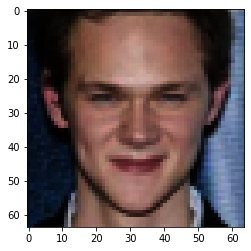

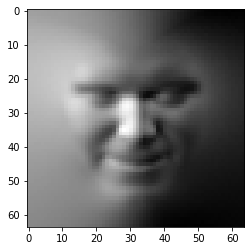

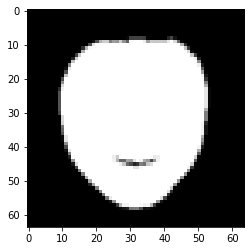

In [165]:
SampleCelebAdisp(2)


(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-129.1863 125.81370000000001


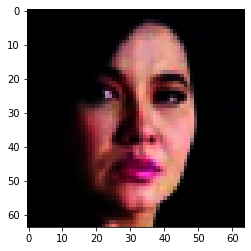

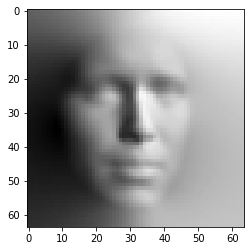

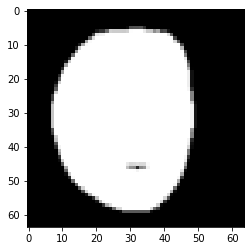

In [166]:
SampleCelebAdisp(60)

# TRAINING THE MODEL ON AUGEMENTED CelebA DATASET FORM **"Neural Face Editing with Intrinsic Image Disentangling"**



# **TRAINING THE MODEL**

# **DECODING THE PARAMETERS FROM THE UNET **

In [167]:
def decoding_parameters(parameters, illumA, illumDNorm, illumFNorm, PC, mu, EV, wavelength, new_skin_color, t_matrix):
  weightA, weightD, Fweights, CCT, b_prediction, b_grid, fmel, fblood, predicted_shading, spec_mask, light_prediction = parameters["weightA"], parameters["weightD"], parameters["Fweights"], parameters["CCT"], parameters["b_prediction"], parameters["b_grid"], parameters["fmel"], parameters["fblood"], parameters["predictedShading"], parameters["specmask"], parameters["light_prediction"]
  e = illuminationModel(weightA, weightD, Fweights, CCT, illumA, illumDNorm, illumFNorm)
  s_r, s_g, s_b = cameraModel(mu, PC, b_prediction, wavelength)
  light_color = computelightcolour(e, s_r, s_g, s_b)
  specularities = computeSpecularities(spec_mask, light_color)
  r_total = BiotoSpectralRF(fmel, fblood, new_skin_color)
  raw_appearance, diffuse_albedo = ImageFormation(r_total, s_r, s_g, s_b, e, specularities, predicted_shading)
  image_white_balanced = WhiteBalance(raw_appearance, light_color)
  t_raw2xyz = findT(t_matrix, b_grid)
  s_rgb_image = fromRawTosRGB(image_white_balanced, t_raw2xyz)
  return s_rgb_image, predicted_shading, specularities, b_prediction, diffuse_albedo

# **Loss Calculation for : prior loss, appearance loss, specularity loss and shading loss**

# NOTE: 
  # image shape is 64 * 64 as obtained from augmented CelebA dataset and not 224 * 224 therefore the fmel, fblood, shading, and specmask are 64*64 as opposed to 224 * 224 mentioned in the matlab repo , hence the appearance loss is being divided by 64 and not 224 as in the code. This may have resulting in varying looking results.

In [172]:


# WEIGHT PARAMETERS 
blossweight = 1e-4  
appweight = 1e-3
Shadingweight = 1e-5
sparseweight = 1e-5 

def loss_calculation(images, rgbim, predictedShading, actualshading, actualmasks, specularities, b_prediction):
  # (16, 3, 1, 1) due to ((16, 3, 256, 256) * (16, 1, 256, 256) -> (16, 3, 1, 1)) / ((16, 1, 256,256)**2 -> (16, 1, 1, 1))
  scale = torch.sum(actualshading * predictedShading *actualmasks, dim=(-1, -2), keepdim=True) / torch.sum(predictedShading * predictedShading *actualmasks, dim=(-1, -2), keepdim=True)
  # (16, 1, 256, 256) due to (16, 1, 256, 256) * (16, 1, 1, 1)
  predictedShading = predictedShading * scale
  # (16, 3, 256, 256)
  alpha = (actualshading - predictedShading) *actualmasks
  delta = (images - rgbim) *actualmasks
  appearance_loss = appweight * torch.sum(delta**2) / (64 * 64)
  b_loss = blossweight * torch.sum(b_prediction**2)
  shading_loss = Shadingweight * torch.sum(alpha**2)
  sparsity_loss = sparseweight * torch.sum(specularities)
  return b_loss , appearance_loss , shading_loss , sparsity_loss

In [176]:
small_dataset = True # used for overfitting a small number of images; set to False for 60/20/20 split on 50k images.
learning_rate = 1e-5 # MATLAB repo says 1e-5
batch_size = 2 if small_dataset else 64 # MATLAB repo chooses 64, but we are overfitting a small dataset below.
%cd /content/Biofacenet_matlab
illumA, illum_d_measured, illum_f,Newskincolour, t_matrix = np.tile(scipy.io.loadmat("BioFaces/util/illumA.mat")["illumA"], (batch_size,1,1)).squeeze(), scipy.io.loadmat("BioFaces/util/illumDmeasured.mat")["illumDmeasured"].reshape(1, 1, 33, 22), scipy.io.loadmat("BioFaces/util/illF.mat")["illF"].reshape(1, 1, 33, 12), np.tile(np.moveaxis(scipy.io.loadmat("BioFaces/util/Newskincolour.mat")["Newskincolour"], -1, 0), (batch_size, 1, 1, 1)), np.tile(scipy.io.loadmat("BioFaces/util/Tmatrix.mat")["Tmatrix"][np.newaxis,...], (batch_size, 1, 1, 1))
illumA /= np.sum(illumA)
illumDNorm = (illum_d_measured / illum_d_measured.sum(axis=-1, keepdims=True)).squeeze()
illumFNorm = (illum_f / illum_f.sum(axis=-1, keepdims=True)).squeeze()
illumA, illumDNorm, illumFNorm,Newskincolour, t_matrix = torch.from_numpy(illumA), torch.from_numpy(illumDNorm), torch.from_numpy(illumFNorm), torch.from_numpy(Newskincolour), torch.from_numpy(t_matrix)
PC, mu, EV = CameraSensitivityPCA(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0])))
PC, mu, EV = torch.from_numpy(PC).float(), torch.from_numpy(mu).float(), torch.from_numpy(EV).float()
wavelength = 33

dataset = CelebADataset(dataset_root_path="/content/drive/MyDrive/Colab Notebooks/NeuralFaceEditingDataset/", small=small_dataset)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def plotMasks(original_image, Srgb_image, predictedShading, specularities, fmel, fblood, diffuseAlbedo,actualmasks):
  from matplotlib import pyplot as plt
  # Srgb_image: (B, 3, H, W), predictedShading: (B, 1, H, W), specularities: (B, 3, H, W), diffuseAlbedo: (B, 3, H, W)
  images_to_display = list(range(0, min(4, original_image.shape[0])))
  for i in images_to_display:
    plt.figure()
    plt.subplot(1, 7, 1)
    plt.imshow(np.moveaxis(((original_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actualmasks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 2)
    plt.imshow(np.moveaxis(( (Srgb_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actualmasks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 3)
    plt.imshow((predictedShading[i]*actualmasks[i]).squeeze(0).cpu().detach().numpy(), cmap='gray')
    plt.subplot(1, 7, 4)
    specularity = np.moveaxis((specularities[i]*actualmasks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(specularity / specularity.max())
    plt.subplot(1, 7, 5)
    plt.imshow((fmel[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 6)
    plt.imshow((fblood[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 7)
    plottable_diffuseAlbedo = np.moveaxis((diffuseAlbedo[i]*actualmasks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(plottable_diffuseAlbedo / plottable_diffuseAlbedo.max())
    plt.show()


def augmentedDataloader(dataset, batch_size):
  from torch.utils.data.sampler import SubsetRandomSampler
 # DATA SPLIT NOT MENTIONED IN THE PAPER 
  np.random.seed(seed=42)
  all_samples, train_size, val_size = [i for i in range(len(dataset))], (1.0 if small_dataset else 0.6), (0.0 if small_dataset else 0.2)
  np.random.shuffle(all_samples)
  train_samples, val_samples, test_samples = np.split(all_samples, 
                                                        [int(train_size * len(all_samples)), 
                                                        int((train_size + val_size) * len(all_samples))
                                                        ])
  dataloaders = {
      "train": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_samples), pin_memory=True, drop_last=True),
      "val": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_samples), pin_memory=True, drop_last=True),
      "test": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_samples), pin_memory=True, drop_last=True),
  }
  return dataloaders

dataloaders = augmentedDataloader(dataset, batch_size)

def train_model(model, dataloaders, optimizers, output_path, device, num_epochs=2000, epoch_start=0, phaseDisp=None):
  for epoch in range(epoch_start, num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    
    for phase in ["train", "val"]:
      running_loss, running_b_loss, running_app_loss, running_shading_loss, running_sparsity_loss = 0, 0, 0, 0, 0
      if phase == "train": model.train()
      else: model.eval()

      epoch_size = 0
      for i, batch in enumerate(dataloaders[phase]):
        for optimizer in optimizers: optimizer.zero_grad()
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(batch["image"].float())
          Srgb_image, predictedShading, specularities, b_prediction, diffuseAlbedo = decoding_parameters(outputs, illumA, illumDNorm, illumFNorm, PC, mu, EV, wavelength,Newskincolour, t_matrix)
          scaled_images = batch["image"]
          print(scaled_images.shape[-1])
          scaled_rgb = Srgb_image * 255 - torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((1, 3, 1, 1))
          b_loss, appearance_loss, shading_loss, sparsity_loss = loss_calculation(scaled_images, scaled_rgb, predictedShading, batch["shading"], batch["mask"], specularities, b_prediction)
          loss = b_loss + appearance_loss + shading_loss + sparsity_loss
          if phase == "train":
            loss.backward()
            for optimizer in optimizers: optimizer.step()
        epoch_size += outputs["weightA"].shape[0]
        running_loss += loss.item()
        running_b_loss += b_loss.item()
        running_app_loss += appearance_loss.item()
        running_shading_loss += shading_loss.item()
        running_sparsity_loss += sparsity_loss.item()
      if not epoch_size: continue
      if phaseDisp(phase, epoch):
        plotMasks(scaled_images, scaled_rgb, predictedShading, specularities, outputs["fmel"].float(), outputs["fblood"].float(), diffuseAlbedo, batch["mask"])
        print(f"{phase} average loss: {(running_loss / epoch_size):.4f}")
        # diffuse i_d, specular i_s, melanin fmel, haemoglobin fblood
        print(f"b_loss: {b_loss}, appearance_loss: {running_app_loss/epoch_size}, shading_loss: {running_shading_loss/epoch_size}, sparsity_loss: {running_sparsity_loss/epoch_size}")

/content/Biofacenet_matlab


[Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
), Sequential(
  (0): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=Tr

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


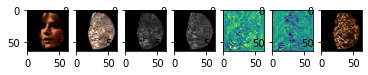

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


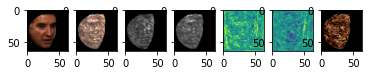

train average loss: 9.8938
b_loss: 9.786332520889118e-05, appearance_loss: 9.818141867638337, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07387775927782059
Epoch 1/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 2/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 3/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 4/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 5/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 6/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 7/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 8/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 9/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 10/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 11/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 12/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


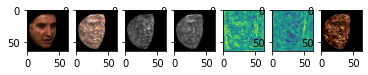

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


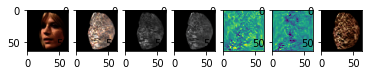

train average loss: 9.7267
b_loss: 0.00034118170151486993, appearance_loss: 9.650805425268134, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07403118908405304
Epoch 31/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 32/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 33/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 34/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 35/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 36/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 37/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 38/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 39/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 40/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 41/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 42/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


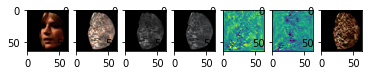

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


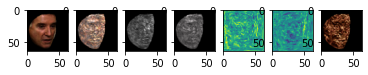

train average loss: 9.5972
b_loss: 0.0005663184565491974, appearance_loss: 9.520888173826027, shading_loss: 0.0017047749204002697, sparsity_loss: 0.0742778405547142
Epoch 61/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 62/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 63/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 64/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 65/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 66/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 67/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 68/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 69/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 70/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 71/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 72/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


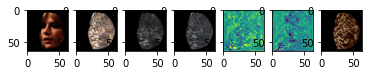

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


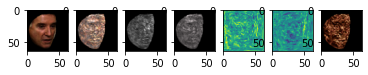

train average loss: 9.5010
b_loss: 0.0008997267577797174, appearance_loss: 9.42409221710255, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07472604513168335
Epoch 91/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 92/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 93/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 94/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 95/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 96/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 97/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 98/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 99/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 100/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 101/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 102/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


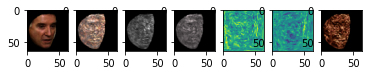

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


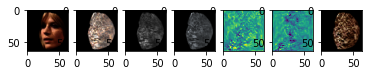

train average loss: 9.4306
b_loss: 0.0012254832545295358, appearance_loss: 9.353056203070157, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07524153590202332
Epoch 121/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 122/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 123/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 124/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 125/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 126/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 127/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 128/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 129/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 130/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 131/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 132/599
torch.Size([2, 1, 64, 64]) torch.Size([

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


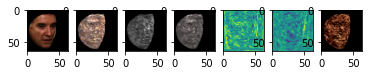

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


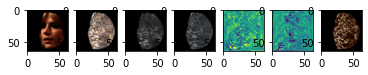

train average loss: 9.3933
b_loss: 0.0014216082636266947, appearance_loss: 9.315374923838128, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07555471360683441
Epoch 151/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 152/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 153/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 154/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 155/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 156/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 157/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 158/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 159/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 160/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 161/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 162/599
torch.Size([2, 1, 64, 64]) torch.Size([

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


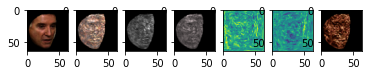

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


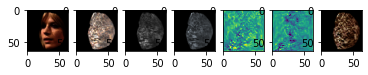

train average loss: 9.3695
b_loss: 0.0015584119828417897, appearance_loss: 9.291317463307566, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07573554664850235
Epoch 181/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 182/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 183/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 184/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 185/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 186/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 187/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 188/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 189/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 190/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 191/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 192/599
torch.Size([2, 1, 64, 64]) torch.Size([

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


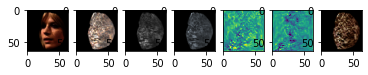

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


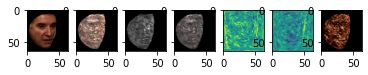

train average loss: 9.3529
b_loss: 0.0016536975745111704, appearance_loss: 9.27451242263595, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07590018212795258
Epoch 211/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 212/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 213/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 214/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 215/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 216/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 217/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 218/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 219/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 220/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 221/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 222/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


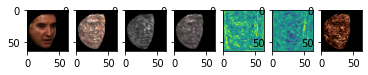

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


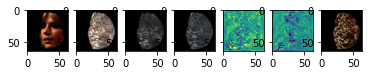

train average loss: 9.3374
b_loss: 0.001761716092005372, appearance_loss: 9.258807211849529, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07603567838668823
Epoch 241/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 242/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 243/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 244/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 245/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 246/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 247/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 248/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 249/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 250/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 251/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 252/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


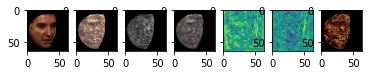

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


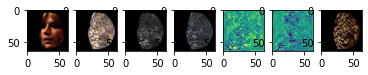

train average loss: 9.3288
b_loss: 0.001814284478314221, appearance_loss: 9.250130948317763, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07608559727668762
Epoch 271/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 272/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 273/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 274/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 275/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 276/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 277/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 278/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 279/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 280/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 281/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 282/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


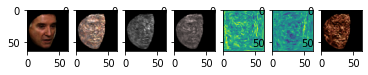

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


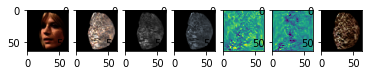

train average loss: 9.3192
b_loss: 0.0018791495822370052, appearance_loss: 9.240380509841348, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07614737749099731
Epoch 301/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 302/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 303/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 304/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 305/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 306/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 307/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 308/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 309/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 310/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 311/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 312/599
torch.Size([2, 1, 64, 64]) torch.Size([

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


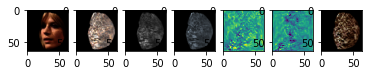

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


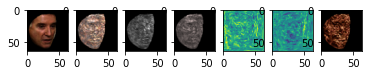

train average loss: 9.3114
b_loss: 0.0019227440934628248, appearance_loss: 9.232516750330635, shading_loss: 0.0017047749204002697, sparsity_loss: 0.0762045606970787
Epoch 331/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 332/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 333/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 334/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 335/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 336/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 337/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 338/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 339/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 340/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 341/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 342/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


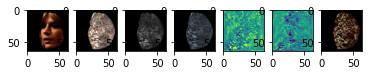

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


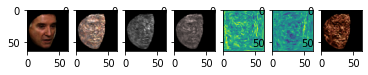

train average loss: 9.3037
b_loss: 0.001973204780369997, appearance_loss: 9.224758304094166, shading_loss: 0.0017047749204002697, sparsity_loss: 0.076273113489151
Epoch 361/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 362/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 363/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 364/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 365/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 366/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 367/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 368/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 369/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 370/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 371/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 372/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


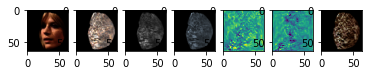

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


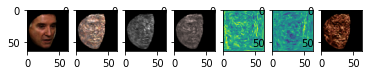

train average loss: 9.2970
b_loss: 0.001998784951865673, appearance_loss: 9.217974230152398, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07631862163543701
Epoch 391/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 392/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 393/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 394/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 395/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 396/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 397/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 398/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 399/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 400/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 401/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 402/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


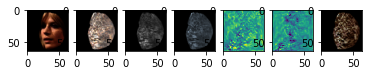

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


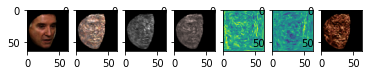

train average loss: 9.2897
b_loss: 0.0020379878114908934, appearance_loss: 9.210559606325516, shading_loss: 0.0017047749204002697, sparsity_loss: 0.076371930539608
Epoch 421/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 422/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 423/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 424/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 425/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 426/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 427/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 428/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 429/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 430/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 431/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 432/599
torch.Size([2, 1, 64, 64]) torch.Size([2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


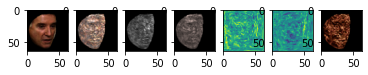

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


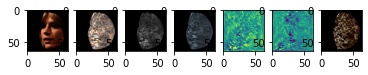

train average loss: 9.2823
b_loss: 0.002076548058539629, appearance_loss: 9.203122544709926, shading_loss: 0.0017047749204002697, sparsity_loss: 0.076417937874794
Epoch 451/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 452/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 453/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 454/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 455/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 456/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 457/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 458/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 459/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 460/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 461/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 462/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


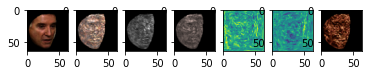

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


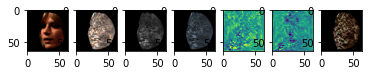

train average loss: 9.2758
b_loss: 0.002109144814312458, appearance_loss: 9.196624845747051, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07645605504512787
Epoch 481/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 482/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 483/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 484/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 485/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 486/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 487/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 488/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 489/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 490/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 491/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 492/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


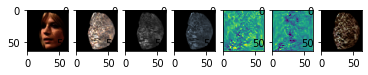

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


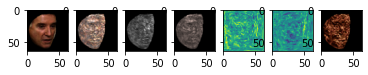

train average loss: 9.2681
b_loss: 0.0021479453425854445, appearance_loss: 9.188796432182695, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07649583369493484
Epoch 511/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 512/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 513/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 514/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 515/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 516/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 517/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 518/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 519/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 520/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 521/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 522/599
torch.Size([2, 1, 64, 64]) torch.Size([

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


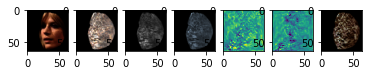

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


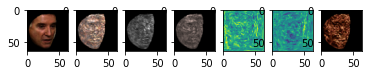

train average loss: 9.2598
b_loss: 0.002198530826717615, appearance_loss: 9.180512009061117, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07651446759700775
Epoch 541/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 542/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 543/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 544/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 545/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 546/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 547/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 548/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 549/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 550/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 551/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 552/599
torch.Size([2, 1, 64, 64]) torch.Size([2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


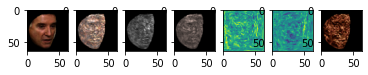

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


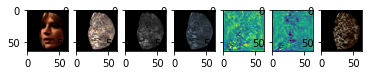

train average loss: 9.2531
b_loss: 0.0022288032341748476, appearance_loss: 9.173776809615811, shading_loss: 0.0017047749204002697, sparsity_loss: 0.07653910666704178
Epoch 571/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 572/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 573/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 574/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 575/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 576/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 577/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 578/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 579/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 580/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 581/599
torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
64
Epoch 582/599
torch.Size([2, 1, 64, 64]) torch.Size([

In [178]:
model = UNet(filters=[32,64,128,256,512], light_vector_size=15, n_class=4, b_size=2, add_double_conv=True)
print(model.encoder_layers)
print(model.decoder_layers_by_class)
print(model.double_conv)
optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate)]
phaseDisp = lambda phase, epoch: phase == "train" and epoch % 30 == 0
train_model(model, dataloaders, optimizers, output_path="/tmp", device=device, num_epochs=600, phaseDisp= phaseDisp)

# **ACTUAL UNET MODEL IMPLEMENTATION FROM UNET PAPER**

In [179]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_channels, out_channels, kernel_size = 3),
      nn.ReLU(inplace = True)
  )
  return conv 


def crop_image(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:,:, delta:tensor_size- delta, delta:tensor_size - delta]

      
    
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.down_conv_1 =  double_conv(1, 64)
    self.down_conv_2 =  double_conv(64,128)
    self.down_conv_3 =  double_conv(128, 256)
    self.down_conv_4 =  double_conv(256,512)
    self.down_conv_5 =  double_conv(512, 1024)

    self.up_trans_1 = nn.ConvTranspose2d(in_channels= 1024, out_channels = 512, kernel_size= 2, stride = 2 )
    self.up_conv_1 = double_conv(1024,512)

    
    self.up_trans_2 = nn.ConvTranspose2d(in_channels= 512, out_channels = 256, kernel_size= 2, stride = 2 )
    self.up_conv_2 = double_conv(512,256)

    
    self.up_trans_3 = nn.ConvTranspose2d(in_channels= 256 , out_channels = 128, kernel_size= 2, stride = 2 )
    self.up_conv_3 = double_conv(256,128)

    
    self.up_trans_4 = nn.ConvTranspose2d(in_channels= 128, out_channels = 64, kernel_size= 2, stride = 2 )
    self.up_conv_4 = double_conv(128,64)

    self.out = nn.Conv2d(in_channels= 64, out_channels = 2, kernel_size= 1)

    
  def forward(self, image):
    # encoder
    x1 = self.down_conv_1(image)
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)

    # decoder
    x = self.up_trans_1(x9)
    y = crop_image(x7, x)
    x = self.up_conv_1(torch.cat([x,y], 1))

    x = self.up_trans_2(x)
    y = crop_image(x5, x)
    x = self.up_conv_2(torch.cat([x,y], 1))

    x = self.up_trans_3(x)
    y = crop_image(x3, x)
    x = self.up_conv_3(torch.cat([x,y], 1))

    x = self.up_trans_4(x)
    y = crop_image(x1, x)
    x = self.up_conv_4(torch.cat([x,y], 1))

    x = self.out(x)

    print(x.size())
    return x


if __name__ == "__main__":
  image = torch.rand((1,1,572,572))
  model = UNet()
  print(model(image))

torch.Size([1, 2, 388, 388])
tensor([[[[0.0610, 0.0624, 0.0590,  ..., 0.0619, 0.0661, 0.0605],
          [0.0583, 0.0589, 0.0590,  ..., 0.0622, 0.0582, 0.0628],
          [0.0606, 0.0621, 0.0635,  ..., 0.0624, 0.0610, 0.0647],
          ...,
          [0.0615, 0.0604, 0.0628,  ..., 0.0629, 0.0561, 0.0618],
          [0.0603, 0.0620, 0.0596,  ..., 0.0644, 0.0629, 0.0634],
          [0.0594, 0.0632, 0.0596,  ..., 0.0603, 0.0614, 0.0596]],

         [[0.0517, 0.0533, 0.0517,  ..., 0.0525, 0.0539, 0.0487],
          [0.0525, 0.0505, 0.0546,  ..., 0.0544, 0.0499, 0.0519],
          [0.0529, 0.0539, 0.0478,  ..., 0.0521, 0.0523, 0.0528],
          ...,
          [0.0520, 0.0544, 0.0526,  ..., 0.0547, 0.0519, 0.0515],
          [0.0540, 0.0530, 0.0508,  ..., 0.0542, 0.0517, 0.0525],
          [0.0511, 0.0575, 0.0487,  ..., 0.0536, 0.0536, 0.0480]]]],
       grad_fn=<MkldnnConvolutionBackward>)
